In [78]:
import hyperpy as hp
from hyperpy.preprocessing.utils import remove_error_specim_line

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt

In [2]:
# Import data
path_to_specim = "/Users/Antoine/Workspace/test-data/hyperspectral-raw-data/REF_1_A.raw"
cube_specim = hp.SpectralCube.from_specim(data_file_name=path_to_specim)

In [5]:
cube_specim_cor = remove_error_specim_line(cube_specim)

In [6]:
# Domain selection: remove noisy wavelengths
domain = cube_specim.domain
domain_selection = hp.DomainSelection(selection=(domain>1100) & (domain<2400),
                                  domain=domain)

In [7]:
mask = hp.RectangleMask(cube_specim.shape[:2], (50, 370), (0,1350))
masked_cube = mask.apply_spectral(cube_specim)

In [8]:
cube_processed = hp.spectral_process(masked_cube, (domain_selection, hp.MeanCentering(),))
data = cube_processed.get_matrix()


In [70]:
def cosine_distance(x, y):
    return 1-cosine_similarity(x, y)

In [101]:
k_range = np.arange(2,10)

In [107]:
kmeans_list, kmeans_classes_list = [], []
n = data.shape[0]

cosine_matrix = np.zeros(shape=(n, len(k_range)))
silhouette_indexes = np.zeros(shape=(len(k_range)))

random_index = choice(np.arange(n), size=int(n*0.15), replace=False)

compute_silhouette = False

for ind_k, k in enumerate(k_range):
    kmeans_obj, kmeans_classes = hp.kmeans(cube_processed, sub_sampling_size=0.33, n_clusters=k)
    kmeans_list.append(kmeans_obj)
    kmeans_classes_list.append(kmeans_classes)
    kmeans_classes_mat = kmeans_classes.get_matrix()
    cosine_sim = np.array([])
    for i in range(k):
        cosine_sim = np.append(cosine_sim,
                               cosine_distance(kmeans_obj.cluster_centers_[i,:].reshape(-1,1).T,
                                               data[kmeans_classes_mat.flatten()==i,:]))
        
    if compute_silhouette:
        silhouette_indexes[ind_k] = silhouette_score(data[random_index, :], kmeans_classes_mat[random_index].flatten())
    
    
    cosine_matrix[:,ind_k] = cosine_sim
    print(f"{k} done.")
    
cosine_sum = cosine_matrix.sum(axis=0)

2 done.
3 done.
4 done.
5 done.
6 done.
7 done.
8 done.
9 done.


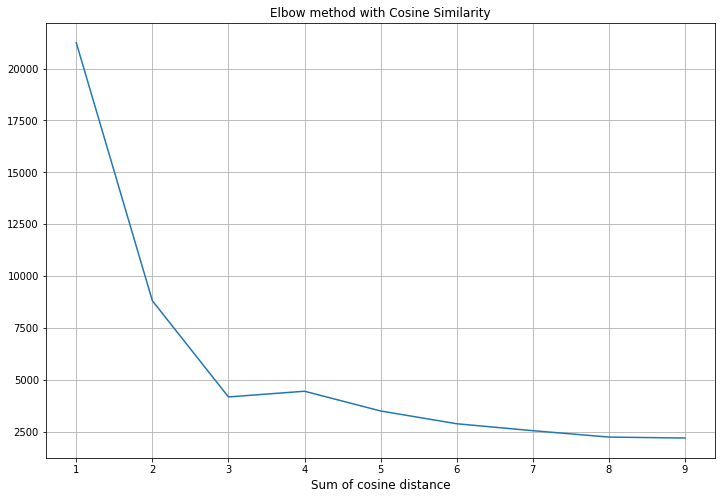

In [68]:
plt.figure(figsize=(12,8))
plt.plot(k_range, cosine_sum)
plt.title('Elbow method with Cosine Similarity')
plt.xlabel('k', fontsize=12)
plt.xlabel('Sum of cosine distance', fontsize=12)
plt.grid()

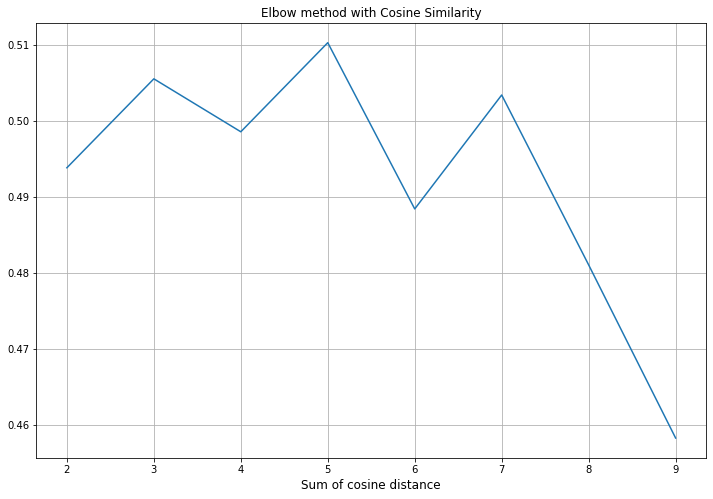

In [105]:
plt.figure(figsize=(12,8))
plt.plot(k_range, silhouette_indexes)
plt.title('Elbow method with Cosine Similarity')
plt.xlabel('k', fontsize=12)
plt.xlabel('Sum of cosine distance', fontsize=12)
plt.grid()

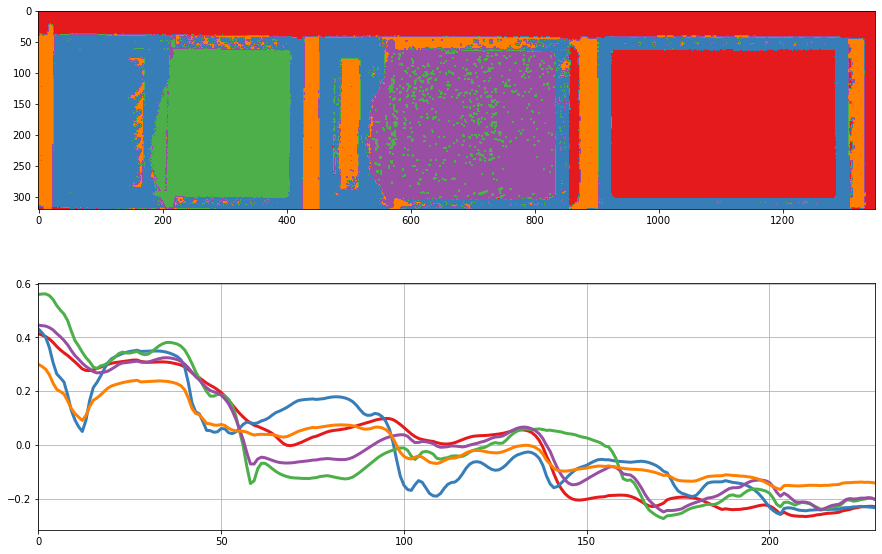

In [114]:
model_index = 3
hp.kmeans_cube_plot(kmeans_list[model_index], kmeans_classes_list[model_index])